In [5]:
# CELL 1: Imports & Setup
# ------------------------------------------------------------------------------
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

# Professional plotting style settings
sns.set_theme(style="whitegrid")
# Increase default font size and figure size for readability in reports
plt.rcParams.update({
    'figure.figsize': (10, 6),
    'savefig.dpi': 300,  # High resolution for your PDF export
    'axes.titlesize': 14,
    'axes.labelsize': 12
})

# Path Definition (Best Practice: Relative Paths)
# We go up one level ("..") from 'notebooks' to access 'data' and 'output'
RAW_DATA_PATH = os.path.join("..", "data", "raw")
OUTPUT_FIG_PATH = os.path.join("..", "output", "figures")

# Create output directory if it doesn't exist (robustness)
os.makedirs(OUTPUT_FIG_PATH, exist_ok=True)

print("✅ Setup complete. Paths defined.")

✅ Setup complete. Paths defined.


In [6]:
# CELL 2: Data Loading
# ------------------------------------------------------------------------------
# We load the two main datasets required for the "Join" task
try:
    # Adjust filenames if they differ slightly in your folder
    df_prev = pd.read_csv(os.path.join(RAW_DATA_PATH, '1- mental-illnesses-prevalence.csv'))
    df_burden = pd.read_csv(os.path.join(RAW_DATA_PATH, '2- burden-disease-from-each-mental-illness(1).csv'))
    
    print(f"✅ Data loaded successfully.")
    print(f"   - Prevalence Data Shape: {df_prev.shape}")
    print(f"   - Burden Data Shape: {df_burden.shape}")

except FileNotFoundError as e:
    print(f"❌ Error: Could not find files in {os.path.abspath(RAW_DATA_PATH)}")
    print("   Please check that file names match exactly.")
    raise e

✅ Data loaded successfully.
   - Prevalence Data Shape: (6420, 8)
   - Burden Data Shape: (6840, 8)


In [7]:
# CELL 3: Data Wrangling (Cleaning & Joining)
# ------------------------------------------------------------------------------

# 1. Rename columns for simplified access
# Map for the prevalence dataset (df_prev)
rename_map_prev = {
    'Entity': 'Country',
    'Code': 'Code',
    'Year': 'Year',
    'Schizophrenia disorders (share of population) - Sex: Both - Age: Age-standardized': 'Schizophrenia',
    'Depressive disorders (share of population) - Sex: Both - Age: Age-standardized': 'Depression',
    'Anxiety disorders (share of population) - Sex: Both - Age: Age-standardized': 'Anxiety',
    'Bipolar disorders (share of population) - Sex: Both - Age: Age-standardized': 'Bipolar',
    'Eating disorders (share of population) - Sex: Both - Age: Age-standardized': 'Eating_Disorders'
}

df_prev = df_prev.rename(columns=rename_map_prev)

# 2. Rename burden dataset columns
# CORRECCIÓN: Usamos el nombre exacto que viene en tu archivo csv número 2
df_burden = df_burden.rename(columns={
    'Entity': 'Country',
    'Year': 'Year',
    'DALYs (rate) - Sex: Both - Age: Age-standardized - Cause: Depressive disorders': 'Depression_DALYs'
})

# 3. The JOIN (Task Requirement: "Join two or more datasets")
# Now 'Depression_DALYs' should exist in df_burden
df_merged = pd.merge(df_prev, df_burden[['Country', 'Year', 'Depression_DALYs']], 
                     on=['Country', 'Year'], 
                     how='inner')

# 4. Filtering / Cleaning
# Drop rows with missing values to ensure statistical validity
df_clean = df_merged.dropna()

print("✅ Wrangling complete.")
print(f"   - Final Joined DataFrame Shape: {df_clean.shape}")
df_clean.head(3) # Preview the clean data

✅ Wrangling complete.
   - Final Joined DataFrame Shape: (6150, 9)


,Country,Code,Year,Schizophrenia,Depression,Anxiety,Bipolar,Eating_Disorders,Depression_DALYs
0,Afghanistan,AFG,1990,0.223206,4.996118,4.713314,0.703023,0.127700,895.22565
1,Afghanistan,AFG,1991,0.222454,4.989290,4.702100,0.702069,0.123256,893.88434
2,Afghanistan,AFG,1992,0.221751,4.981346,4.683743,0.700792,0.118844,892.34973


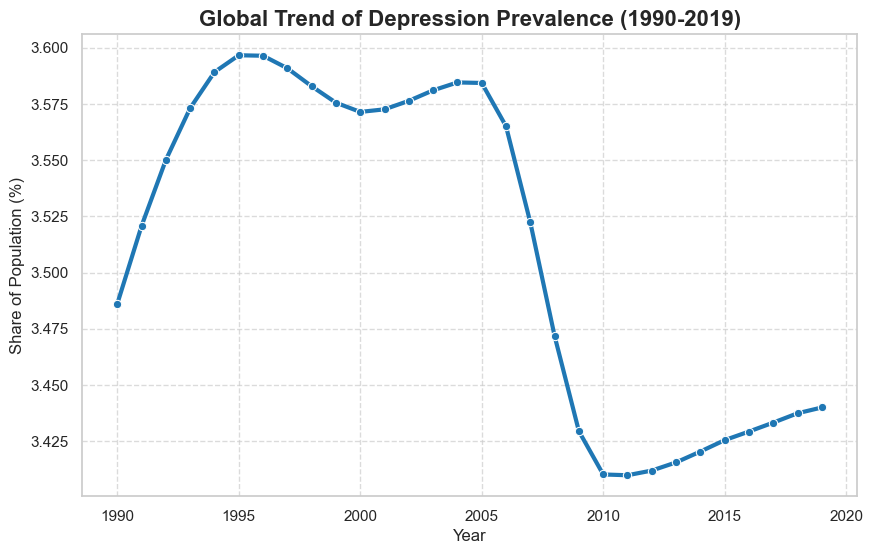

In [8]:
# CELL 4: Profile - Insight 1 (Temporal Trend)
# ------------------------------------------------------------------------------
# Question: How has the global prevalence of depression changed over time?

plt.figure(figsize=(10, 6))

# We filter for 'World' to see the aggregated global trend
data_world = df_clean[df_clean['Country'] == 'World']

# Line plot with markers
sns.lineplot(data=data_world, x='Year', y='Depression', linewidth=3, marker='o', color='#1f77b4')

plt.title('Global Trend of Depression Prevalence (1990-2019)', fontsize=16, fontweight='bold')
plt.ylabel('Share of Population (%)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Save and Show
plt.savefig(os.path.join(OUTPUT_FIG_PATH, 'insight1_trend_depression.png'), bbox_inches='tight')
plt.show()

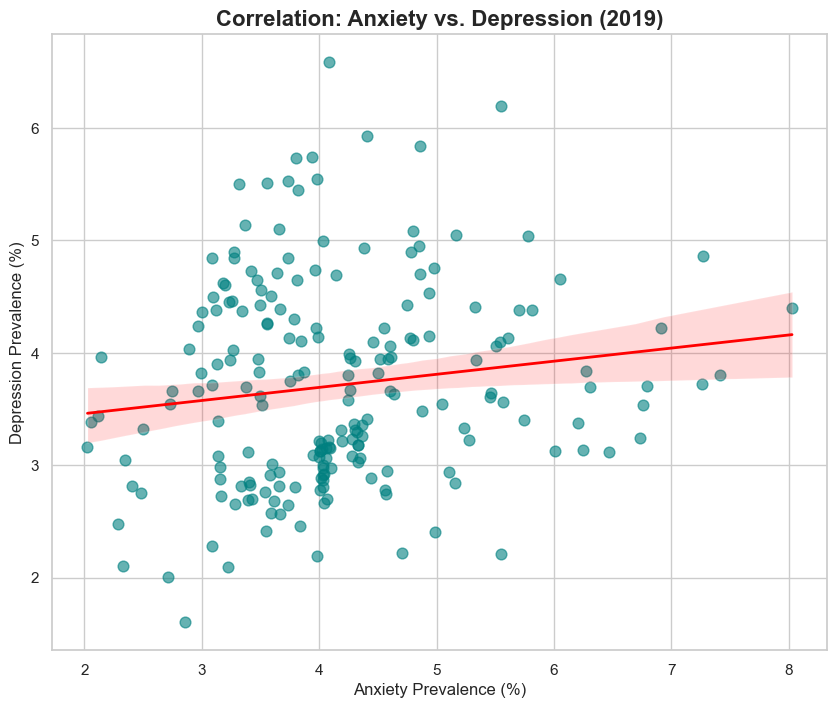

In [9]:
# CELL 5: Profile - Insight 2 (Multivariate Analysis)
# ------------------------------------------------------------------------------
# Question: Is there a correlation between Anxiety and Depression rates across countries?

plt.figure(figsize=(10, 8))

# Filter: Use only the latest year (2019) and exclude 'World' aggregates to avoid bias
data_2019 = df_clean[(df_clean['Year'] == 2019) & (df_clean['Country'] != 'World')]

# Regression Plot (Scatter + Linear Fit)
sns.regplot(data=data_2019, x='Anxiety', y='Depression', 
            scatter_kws={'alpha':0.6, 's':60, 'color': 'teal'}, 
            line_kws={'color':'red', 'linewidth':2})

plt.title('Correlation: Anxiety vs. Depression (2019)', fontsize=16, fontweight='bold')
plt.xlabel('Anxiety Prevalence (%)', fontsize=12)
plt.ylabel('Depression Prevalence (%)', fontsize=12)

# Save and Show
plt.savefig(os.path.join(OUTPUT_FIG_PATH, 'insight2_correlation.png'), bbox_inches='tight')
plt.show()

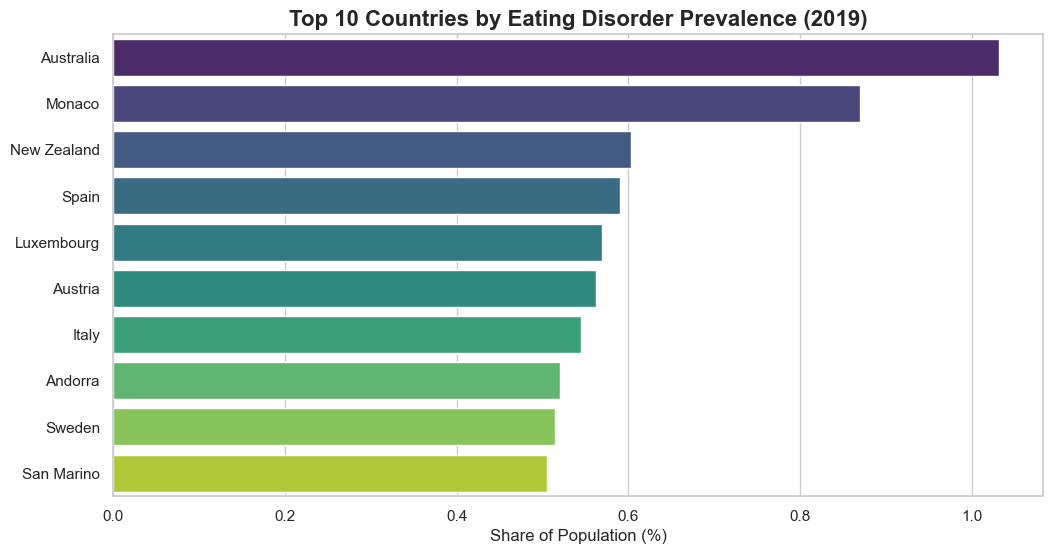

In [10]:
# CELL 6: Profile - Insight 3 (Comparative Ranking)
# ------------------------------------------------------------------------------
# Question: Which countries have the highest prevalence of Eating Disorders?

plt.figure(figsize=(12, 6))

# Sort and take top 10
top_eating = data_2019.sort_values('Eating_Disorders', ascending=False).head(10)

# Barplot
sns.barplot(data=top_eating, x='Eating_Disorders', y='Country', palette='viridis', hue='Country', legend=False)

plt.title('Top 10 Countries by Eating Disorder Prevalence (2019)', fontsize=16, fontweight='bold')
plt.xlabel('Share of Population (%)', fontsize=12)
plt.ylabel('') # Remove y-label as country names are self-explanatory

# Save and Show
plt.savefig(os.path.join(OUTPUT_FIG_PATH, 'insight3_ranking.png'), bbox_inches='tight')
plt.show()

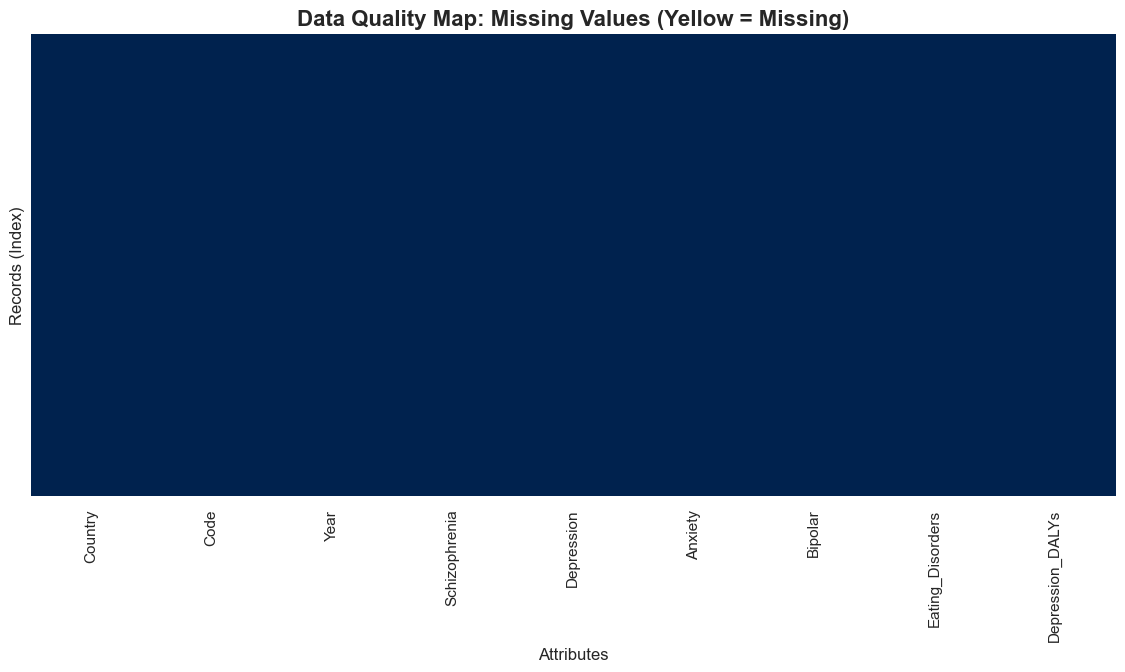

In [11]:
# CELL 7: Data Quality Analysis (Bonus Task)
# ------------------------------------------------------------------------------
# Objective: Visualize Missing Values in the original merged dataset
# This helps identify if data is missing randomly or systematically (e.g. whole years missing)

plt.figure(figsize=(14, 6))

# We use df_merged (before dropping NaNs) to see the missing data
sns.heatmap(df_merged.isnull(), cbar=False, yticklabels=False, cmap='cividis')

plt.title('Data Quality Map: Missing Values (Yellow = Missing)', fontsize=16, fontweight='bold')
plt.xlabel('Attributes', fontsize=12)
plt.ylabel('Records (Index)', fontsize=12)

# Save and Show
plt.savefig(os.path.join(OUTPUT_FIG_PATH, 'insight4_data_quality.png'), bbox_inches='tight')
plt.show()